In [ ]:
from diffusers import UNet2DConditionModel, DDIMScheduler, DDPMScheduler
import torch
from config_file import TrainingConfig
from CustomDataset import CustomDateset
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
config = TrainingConfig()

In [16]:
def check_nearest_neighbors(gen_images, real_images, num_to_check, metric='l2', device='cuda', batch_size=1000):
    """
    Finds and visualizes the nearest neighbor in the real dataset for a set of generated images.
    
    Args:
        gen_images (torch.Tensor): Generated images (B, C, H, W), values in [0, 1]
        real_images (torch.Tensor): Real dataset images (N, C, H, W), values in [0, 1]
        num_to_check (int): Number of random images to visualize
        metric (str): 'l1' (Manhattan) or 'l2' (Euclidean) distance
        device (str): Device for calculation ('cuda' or 'cpu')
        batch_size (int): Size of chunks for processing real images (saves memory)
    """
    print(f"Computing nearest neighbors using {metric.upper()} distance...")
    
    # 1. Randomly select images to check (instead of just the first N)
    n_gen = gen_images.shape[0]
    if n_gen > num_to_check:
        indices = torch.randperm(n_gen)[:num_to_check]
        query_images = gen_images[indices].to(device)
    else:
        query_images = gen_images.to(device)
        num_to_check = n_gen

    # Flatten query images: (num_to_check, features)
    query_flat = query_images.reshape(query_images.shape[0], -1)
    
    # Storage for results
    min_dists = torch.full((num_to_check,), float('inf'), device=device)
    min_indices = torch.zeros((num_to_check,), dtype=torch.long, device=device)
    
    # 2. Process real images in batches to avoid OOM on GPU
    n_real = real_images.shape[0]
    
    # We loop over the real dataset
    for i in range(0, n_real, batch_size):
        end = min(i + batch_size, n_real)
        real_batch = real_images[i:end].to(device)
        
        # Flatten real batch: (batch_size, features)
        real_flat = real_batch.reshape(real_batch.shape[0], -1)
        
        # Compute distances
        # shapes: query_flat (M, D), real_flat (Batch, D)
        if metric == 'l1':
            # L1 = sum(|x - y|) -> efficient via cdist with p=1
            dists = torch.cdist(query_flat, real_flat, p=1)
        else:
            # L2 = sqrt(sum((x - y)^2))
            dists = torch.cdist(query_flat, real_flat, p=2)
            
        # Find min for this batch
        batch_min_dists, batch_min_idx = dists.min(dim=1)
        
        # Update global minimums
        mask = batch_min_dists < min_dists
        min_dists[mask] = batch_min_dists[mask]
        min_indices[mask] = batch_min_idx[mask] + i # Add offset 'i'
        
    # 3. Plotting
    print("Plotting results...")
    # Move results to CPU for plotting
    query_images = query_images.cpu()
    real_images_subset = real_images[min_indices.cpu()].cpu() # Fetch only the winners
    min_dists = min_dists.cpu()

    # Create figure: 3 columns (Gen, Nearest Real, Diff)
    fig, axes = plt.subplots(num_to_check, 3, figsize=(12, 3 * num_to_check))
    
    if num_to_check == 1: axes = [axes] # Handle single row case

    for i in range(num_to_check):
        gen_np = query_images[i].permute(1, 2, 0).numpy()
        real_np = real_images_subset[i].permute(1, 2, 0).numpy()
        
        # Calculate Difference Map (Absolute difference)
        diff_map = np.abs(gen_np - real_np)
        diff_map = diff_map.mean(axis=2) # Average over channels for grayscale heatmap

        # Column 1: Generated
        axes[i][0].imshow(np.clip(gen_np, 0, 1))
        axes[i][0].set_title("Generated")
        axes[i][0].axis("off")

        # Column 2: Nearest Real
        axes[i][1].imshow(np.clip(real_np, 0, 1))
        axes[i][1].set_title(f"Nearest Real\n({metric.upper()}: {min_dists[i]:.2f})")
        axes[i][1].axis("off")
        
        # Column 3: Difference Map
        im = axes[i][2].imshow(diff_map, cmap='hot', vmin=0, vmax=1)
        axes[i][2].set_title("Difference Map")
        axes[i][2].axis("off")
        
        # Optional: Add borders to diff map to make it distinct
        for spine in axes[i][2].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(1)

    plt.tight_layout()
    plt.savefig("nearest_neighbors_check1.png")
    plt.show()
    print("Saved plot to nearest_neighbors_check.png")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
path = "C:/Users/HP/.cache/kagglehub/datasets/ebrahimelgazar/pixel-art/versions/1"
#force use local model
model = UNet2DConditionModel.from_pretrained("C:/Users/HP/Desktop/VSCODE_FILES/deep_learning_project/pixelart_ddpm_version4/unet", use_safetensors=True)
model.to(device)
dataset = CustomDateset(path + "/sprites.npy", path + "/sprites_labels.npy")
dataloader = DataLoader(dataset, batch_size = config.train_batch_size, shuffle = True, num_workers=2, pin_memory=True)
    



In [ ]:
all_real_images = []
with torch.no_grad():
    for real_images, _ in tqdm(dataloader, desc="FID real"):
        real_images = real_images.to(device)
        real_images = ((real_images + 1) / 2).clamp(0, 1)
        all_real_images.append(real_images.cpu())
all_real_images = torch.cat(all_real_images, dim = 0)  # (N, C, H, W)

target_class = 3
real_class_images = []

with torch.no_grad():
    for imgs, labels in dataloader:
        mask = labels == target_class
        if mask.any():
            imgs = imgs[mask]
            imgs = ((imgs + 1) / 2).clamp(0, 1)
            real_class_images.append(imgs)

real_class_images = torch.cat(real_class_images, dim=0)

In [42]:
# 1. class =  hayvanlar = zor öğreniyo

# 3. class = eşyalar,silahlar = kolay öğrendikleri
# 4. class = silahlı npcler = orta zorluk?
guidance_scale = 5.0
null_class = dataset.labels.max().item() + 1
# real images


noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler = DDIMScheduler.from_config(noise_scheduler.config)
noise_scheduler.set_timesteps(25)

    # fake images
all_fake_images = []
with torch.no_grad():
    for _ in range(50):
        cond_label = torch.tensor([target_class], device=device, dtype=torch.long)
        uncond_label = torch.tensor([null_class], device=device, dtype=torch.long)

        combined_labels = torch.cat([cond_label, uncond_label])
        

        fake_images = torch.randn((1,
                                3,
                                    config.image_size, 
                                    config.image_size), 
                                    device=device)
            
        for t in noise_scheduler.timesteps:
            latent_model_input = torch.cat([fake_images] * 2)
            latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t)
            noise_pred = model(latent_model_input, 
                                t, 
                                class_labels=combined_labels,
                                return_dict=False,
                                encoder_hidden_states = None)[0]
            noise_pred_cond, noise_pred_uncond = noise_pred.chunk(2)

            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

            fake_images = noise_scheduler.step(noise_pred,t,fake_images).prev_sample
            
        fake_images = ((fake_images.clamp(-1, 1) + 1) / 2).clamp(0, 1)
        all_fake_images.append(fake_images.cpu())

all_fake_images = torch.cat(all_fake_images, dim=0)

In [ ]:
model.eval()
with torch.no_grad():
    x = torch.randn((1, 3, config.image_size, config.image_size), device=device)
    t = torch.tensor([500], device=device)

    out_a = model(x, t, class_labels=torch.tensor([0], device=device), encoder_hidden_states = None).sample
    out_b = model(x, t, class_labels=torch.tensor([4], device=device), encoder_hidden_states = None).sample

    print(torch.mean(torch.abs(out_a - out_b)).item())
print(model.class_embedding)
print(model.class_embedding.linear_1.weight.shape)


In [ ]:
check_nearest_neighbors(all_fake_images, real_class_images, num_to_check=20, metric='l2', device = device) 

Found 35000 images for Class 3


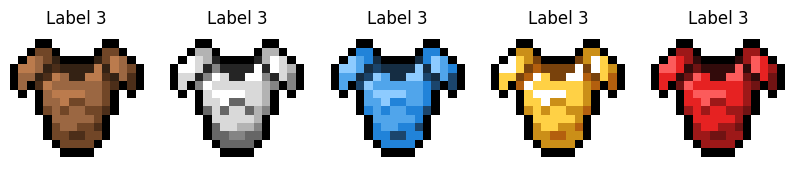

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the raw data
images = np.load(path + "/sprites.npy")
raw_labels = np.load(path + "/sprites_labels.npy")

# 2. Convert One-Hot to Indices (Just like your Dataset class)
if raw_labels.ndim == 2:
    labels = np.argmax(raw_labels, axis=1)
else:
    labels = raw_labels

# 3. NOW search for the class (e.g., Class 3 for NPCs)
target_check = 3 
indices = np.where(labels == target_check)[0]

print(f"Found {len(indices)} images for Class {target_check}")

# 4. Visualize
plt.figure(figsize=(10, 2))
for i in range(min(5, len(indices))): # Safety check in case < 5 images
    idx = indices[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(images[idx]) 
    plt.axis('off')
    plt.title(f"Label {target_check}")
plt.show()